# Evaluation of the 3 datasets with ML

In [1]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression   
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return ' '.join(word for word in lemmatized)

def plot_learning_curve(model, Name, X_train, y_train):

    train_sizes = np.linspace(0.1, 1, 15)
    
    train_sizes, train_scores, test_scores = learning_curve(
                  model, X_train, y_train, 
                  train_sizes = train_sizes,
                  cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title(f"Model - {Name}")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "CV Test score")
    plt.legend(loc="best")
    plt.show()


def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)

def get_scores(model, model_name, X_train, y_train, X_test, y_test):
    
    # Cross Validation
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring = scoring)

    acc = cv_results['test_accuracy'].mean()
    recall = cv_results['test_recall'].mean()
    precision = cv_results['test_precision'].mean()
    f1 = cv_results['test_f1'].mean()
    
    print('-'*80)
    print(f"{model_name} - CV scores: ")
    print('-'*80)
    print(f"Acc : {acc:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"f1: {f1:.2f}")
    
    # Test evaluation
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print('-'*80)
    print(f"{model_name} - test scores: ")
    binary_metrics(y_test, y_preds)
    
    return acc, recall, precision, f1

def save_model(model, model_name = 'model.joblib'):
    """
    Save the model into a .joblib format
    """
    joblib.dump(model, model_name)
    print(colored('-'*80, 'green'))
    print(colored(f"{model_name} saved locally", "green"))
    print(colored('-'*80, 'green'))

def get_model(path_to_joblib):
    pipeline = joblib.load(path_to_joblib)
    return pipeline

## Loading Datasets

### Loading `politifact_scrap.csv`

In [3]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [4]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: washington public school force unvaccinated teen wear ankle monitor condition playing team sport
--------------------------------------------------------------------------------


In [5]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


### Loading `FakeNewsNET`

In [6]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [7]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: djou win special election congress
--------------------------------------------------------------------------------


In [8]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [9]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [10]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [11]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [12]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: u budget fight loom republican flip fiscal script
--------------------------------------------------------------------------------


In [13]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


### Merging `All`

In [14]:
X_all = pd.concat([X_P, X_FNN, X_BIS]).reset_index(drop=True)
y_all = pd.concat([y_P, y_FNN, y_BIS]).reset_index(drop=True)

print('-'*80)
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_all shape: (83796,)
y_all shape: (83796,)
--------------------------------------------------------------------------------


In [15]:
X_ALL_train, X_ALL_test, y_ALL_train, y_ALL_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_ALL_train shape: {X_ALL_train.shape}")
print(f"y_ALL_train shape: {y_ALL_train.shape}")
print('-'*80)
print(f"X_ALL_test shape: {X_ALL_test.shape}")
print(f"y_ALL_test shape: {y_ALL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALL_train.sum()/len(y_ALL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALL_test.sum()/len(y_ALL_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train shape: (67036,)
y_ALL_train shape: (67036,)
--------------------------------------------------------------------------------
X_ALL_test shape: (16760,)
y_ALL_test shape: (16760,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 46.453
Fake (1) proportion in test (%): 46.718
--------------------------------------------------------------------------------


#### Checking foreign characters

In [16]:
# vectorizer = TfidfVectorizer()
# X_vec = vectorizer.fit_transform(X_FNN)

# X_vec_df = pd.DataFrame(X_vec.toarray(), columns = vectorizer.get_feature_names())

# print('-'*80)
# print(f"X_vec shape: {X_train_vec.shape}")
# print('-'*80)
# print(X_vec_df.head())
# print('-'*80)

In [ ]:
# data_FNN['title'].str.contains('ы').sum()

## `politifact_scrap.csv`

### Preprocessing

In [32]:
vectorizer_P = TfidfVectorizer()
X_P_train_vec = vectorizer_P.fit_transform(X_P_train)
X_P_test_vec = vectorizer_P.transform(X_P_test)

X_P_train_vec_df = pd.DataFrame(X_P_train_vec.toarray(), columns = vectorizer_P.get_feature_names())

print('-'*80)
print(f"X_P_train_vec shape: {X_P_train_vec.shape}")
print(f"X_P_test_vec shape: {X_P_test_vec.shape}")
print('-'*80)
print(X_P_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_vec shape: (15860, 12692)
X_P_test_vec shape: (3966, 12692)
--------------------------------------------------------------------------------
    aa  aaa  aaron  aarp   ab  aba  abaco  abandoned  abbas  abbott  ...  \
0  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
1  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
2  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
3  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
4  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   

   zoning  zoo  zoom  zpass  zuber  zucker  zuckerberg  zyphr  único  ḍozen  
0     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
1     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
2     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  

### Logistic Regression

--------------------------------------------------------------------------------
Logistic Reg - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.73
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------
Logistic Reg - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.72
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------


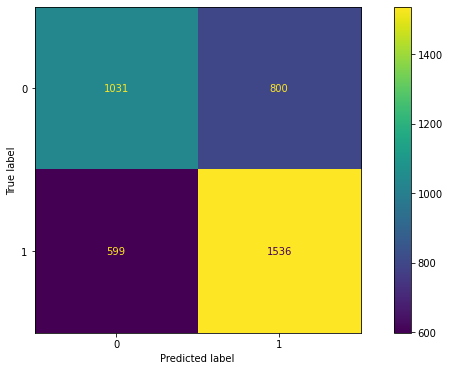

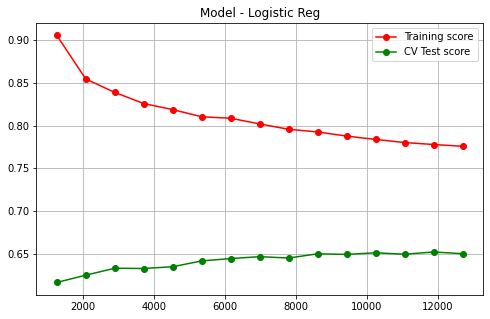

In [18]:
log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
acc, recall, precision, f1 = get_scores(log_model, 'Logistic Reg', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

plot_confusion_matrix(log_model, X_P_test_vec, y_P_test, values_format='d');

plot_learning_curve(log_model, 'Logistic Reg', X_P_train_vec, y_P_train)

### Logistic Regression - Fine-Tuning

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log_reg', LogisticRegression(max_iter=1000)),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'log_reg__C': (0.01, 0.1, 1, 10)
}

lg_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

lg_grid_search.fit(X_P_train, y_P_train)

print('-'*80)
print(f"Best parameters: {lg_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'log_reg__C': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Log Reg - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.66
Recall: 0.68
Precision: 0.69
f1: 0.69
--------------------------------------------------------------------------------
Log Reg - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.68
Precision: 0.69
f1: 0.68
--------------------------------------------------------------------------------


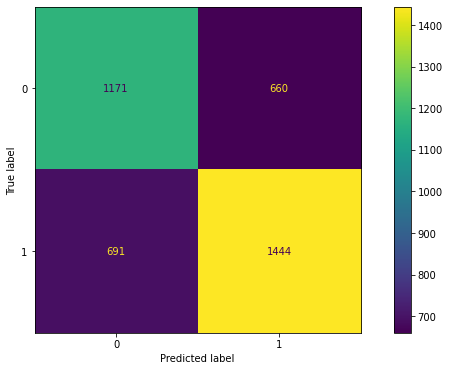

In [20]:
acc, recall, precision, f1 = get_scores(lg_grid_search.best_estimator_, 'Log Reg - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(lg_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.70
Precision: 0.67
f1: 0.69
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.69
Precision: 0.67
f1: 0.68
--------------------------------------------------------------------------------


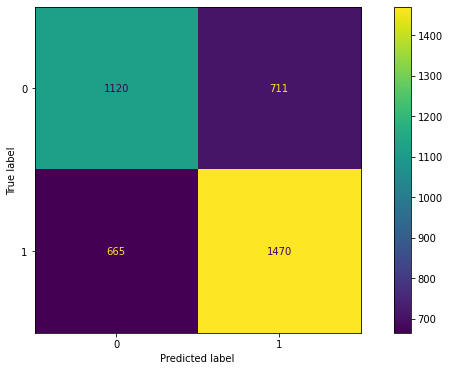

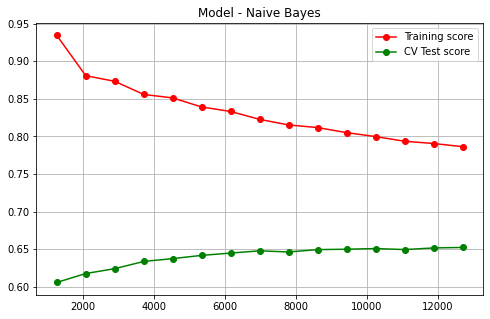

In [21]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

plot_confusion_matrix(nb_model, X_P_test_vec, y_P_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train)

### Naive Bayes - Fine-Tuning

In [22]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_P_train, y_P_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


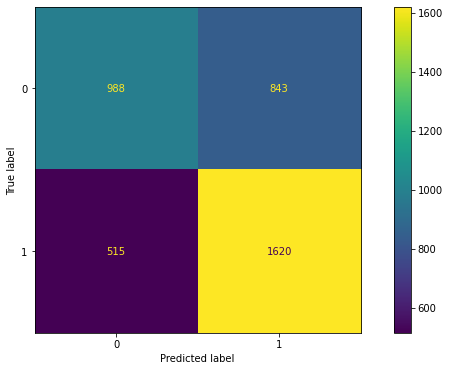

In [23]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### SVM

In [24]:
# svm_model = SVC()
# acc, recall, precision, f1 = get_scores(svm_model, 'SVM', X_train_vec, y_train, X_test_vec, y_test)

# plot_confusion_matrix(svm_model, X_test_vec, y_test, values_format='d');

# # plot_learning_curve(svm_model, 'SVM', X_train_vec, y_train)

### Random Forest

In [25]:
# forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
# acc, recall, precision, f1 = get_scores(forest_model, 'RandomForest', X_train_vec, y_train, X_test_vec, y_test)

# plot_confusion_matrix(forest_model, X_test_vec, y_test, values_format='d');

# # plot_learning_curve(forest_model, 'RandomForest', X_train_vec, y_train)

### Saving the model

In [26]:
model_name = '../raw_data/P_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/P_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [27]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


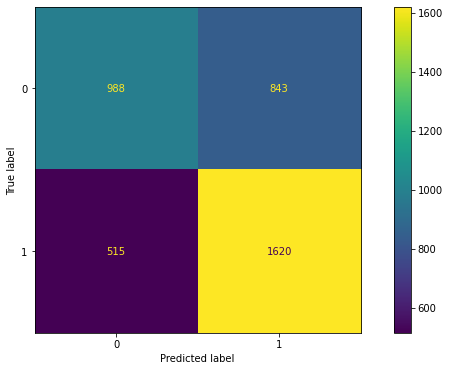

In [28]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `P_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/P_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.29
Recall: 0.94
Precision: 0.25
f1: 0.39
--------------------------------------------------------------------------------


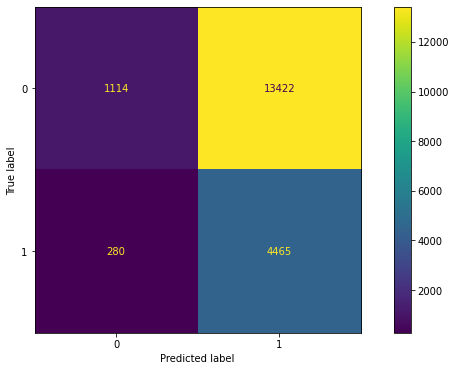

In [29]:
model_name = '../raw_data/P_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_FNN)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN, y_preds)

plot_confusion_matrix(model, X_FNN, y_FNN, values_format='d');

### `P_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/P_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.56
Recall: 0.97
Precision: 0.55
f1: 0.70
--------------------------------------------------------------------------------


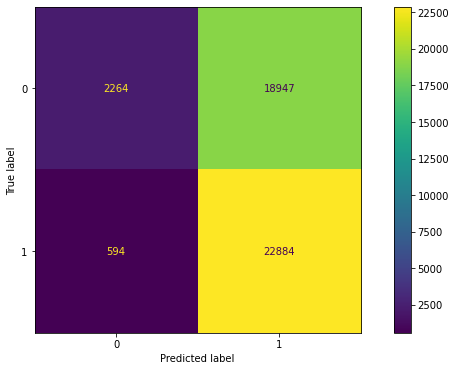

In [30]:
model_name = '../raw_data/P_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_BIS)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS, y_preds)

plot_confusion_matrix(model, X_BIS, y_BIS, values_format='d');

## `FakeNewsNET`

### Preprocessing

In [33]:
vectorizer_F = TfidfVectorizer()
X_FNN_train_vec = vectorizer_F.fit_transform(X_FNN_train)
X_FNN_test_vec = vectorizer_F.transform(X_FNN_test)

X_FNN_train_vec_df = pd.DataFrame(X_FNN_train_vec.toarray(), columns = vectorizer_F.get_feature_names())

print('-'*80)
print(f"X_FNN_train_vec shape: {X_FNN_train_vec.shape}")
print(f"X_FNN_test_vec shape: {X_FNN_test_vec.shape}")
print('-'*80)
print(X_FNN_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_vec shape: (15424, 12773)
X_FNN_test_vec shape: (3857, 12773)
--------------------------------------------------------------------------------
   aaliyah  aaron   ab  abandon  abasolo  abba  abbey  abbi  abbie  abbott  \
0      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
1      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
2      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
3      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
4      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   

   ...  букмекерская  вин  контора  монако  пернелл  питт  принцессы  ради  \
0  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
1  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
2  ...           0.0  0.0      0.0     0.0      0.0   0.0    

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.80
Recall: 0.25
Precision: 0.84
f1: 0.39
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.29
Precision: 0.81
f1: 0.43
--------------------------------------------------------------------------------


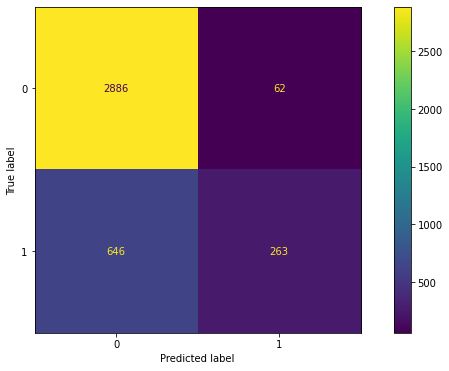

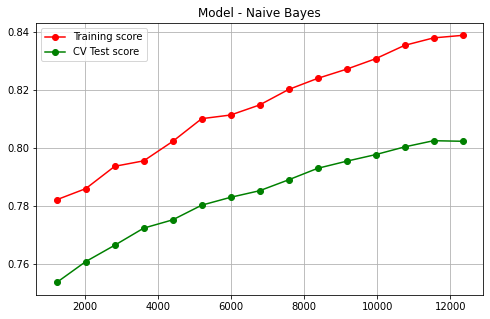

In [34]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train, X_FNN_test_vec, y_FNN_test)

plot_confusion_matrix(nb_model, X_FNN_test_vec, y_FNN_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train)

### Naives Bayes - Fine Tuning

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_FNN_train, y_FNN_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.45
Precision: 0.72
f1: 0.55
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.49
Precision: 0.71
f1: 0.58
--------------------------------------------------------------------------------


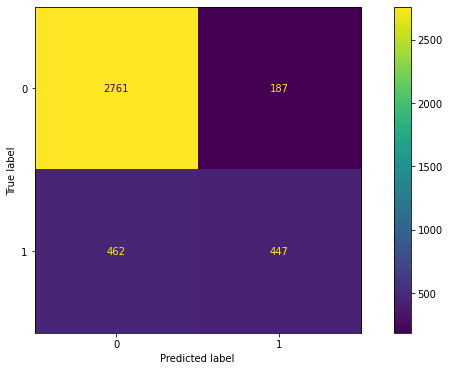

In [36]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_FNN_train, y_FNN_train, X_FNN_test, y_FNN_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_FNN_test, y_FNN_test, values_format='d');

### Saving the model

In [37]:
model_name = '../raw_data/F_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/F_model.joblib saved locally
--------------------------------------------------------------------------------


### Upload the model

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.45
Precision: 0.72
f1: 0.55
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.49
Precision: 0.71
f1: 0.58
--------------------------------------------------------------------------------


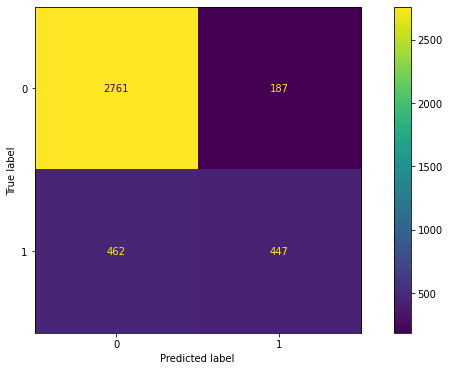

In [38]:
model = get_model(model_name)

acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_FNN_train, y_FNN_train, X_FNN_test, y_FNN_test)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `F_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/F_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.50
Recall: 0.24
Precision: 0.56
f1: 0.33
--------------------------------------------------------------------------------


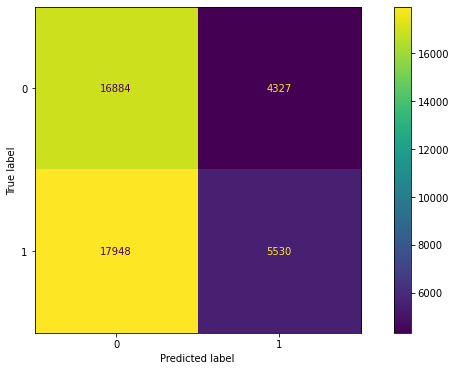

In [39]:
model_name = '../raw_data/F_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_BIS)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS, y_preds)

plot_confusion_matrix(model, X_BIS, y_BIS, values_format='d');

### `F_model.joblib` evaluation on  `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/F_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.50
Recall: 0.15
Precision: 0.70
f1: 0.24
--------------------------------------------------------------------------------


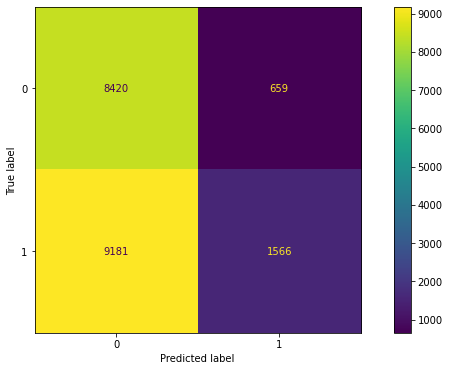

In [40]:
model_name = '../raw_data/F_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_P)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P, y_preds)

plot_confusion_matrix(model, X_P, y_P, values_format='d');

## `Bisaillon`

### Preprocessing

In [42]:
vectorizer_B = TfidfVectorizer()
X_BIS_train_vec = vectorizer_B.fit_transform(X_BIS_train)
X_BIS_test_vec = vectorizer_B.transform(X_BIS_test)

X_BIS_train_vec_df = pd.DataFrame(X_BIS_train_vec.toarray(), columns = vectorizer_B.get_feature_names())

print('-'*80)
print(f"X_BIS_train_vec shape: {X_BIS_train_vec.shape}")
print(f"X_BIS_test_vec shape: {X_BIS_test_vec.shape}")
print('-'*80)
print(X_BIS_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_vec shape: (35751, 16430)
X_BIS_test_vec shape: (8938, 16430)
--------------------------------------------------------------------------------
    aa  aar  aardvark  aaron  aarp  abadi  abandon  abandoned  abandoning  \
0  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
1  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
2  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
3  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
4  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   

   abbas  ...  zor  zschaepe  zucker  zuckerberg  zulia  zuma  zummar  zurich  \
0    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
1    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
2    0.0  ...  0.0       0.0     0.0         0.0    0.0   

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.93
Recall: 0.95
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.94
Recall: 0.96
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------


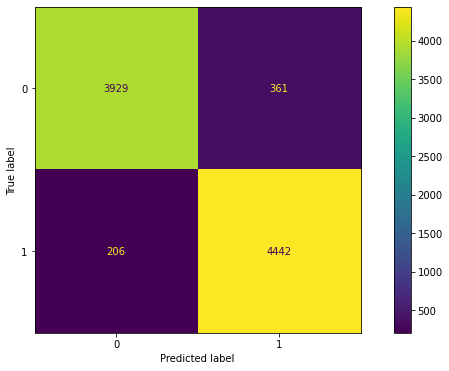

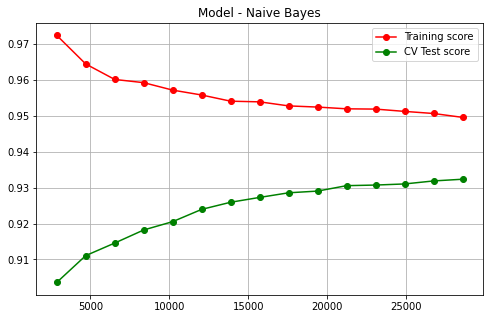

In [43]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train, X_BIS_test_vec, y_BIS_test)

plot_confusion_matrix(nb_model, X_BIS_test_vec, y_BIS_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train)

### Naive Bayes - Fine-Tuning

In [44]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_BIS_train, y_BIS_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


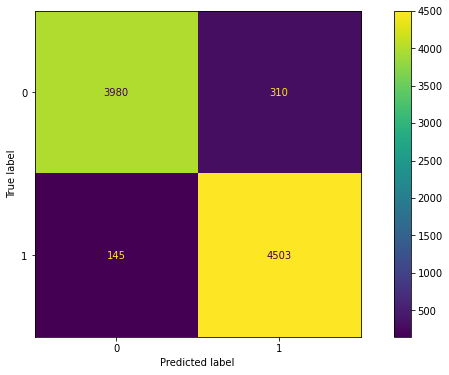

In [45]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_BIS_train, y_BIS_train, X_BIS_test, y_BIS_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_BIS_test, y_BIS_test, values_format='d');

### Saving the model

In [49]:
model_name = '../raw_data/B_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/B_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [50]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


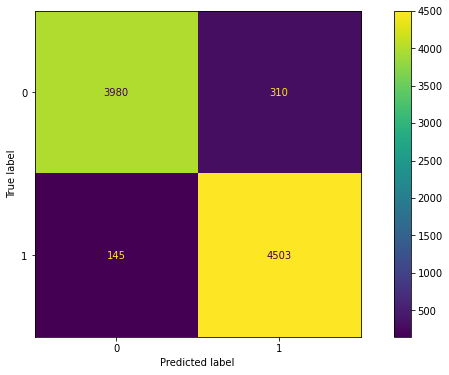

In [51]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_BIS_train, y_BIS_train, X_BIS_test, y_BIS_test)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

### `B_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/B_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.31
Recall: 0.89
Precision: 0.25
f1: 0.39
--------------------------------------------------------------------------------


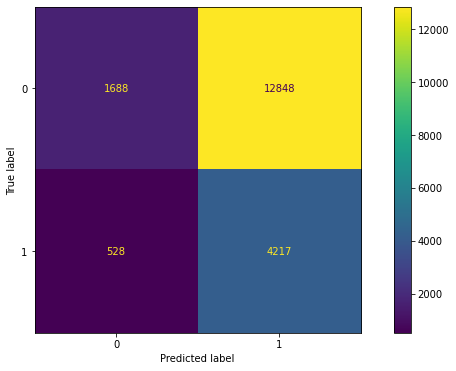

In [52]:
model_name = '../raw_data/B_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_FNN)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN, y_preds)

plot_confusion_matrix(model, X_FNN, y_FNN, values_format='d');

### `B_model.joblib` evaluation on `politifact scrap`

--------------------------------------------------------------------------------
../raw_data/B_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.56
Recall: 0.73
Precision: 0.58
f1: 0.65
--------------------------------------------------------------------------------


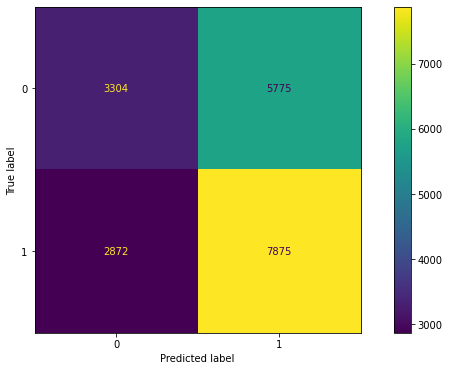

In [53]:
model_name = '../raw_data/B_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_P)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P, y_preds)

plot_confusion_matrix(model, X_P, y_P, values_format='d');

## `All`

### Preprocessing

In [54]:
vectorizer_ALL = TfidfVectorizer()
X_ALL_train_vec = vectorizer_ALL.fit_transform(X_ALL_train)
X_ALL_test_vec = vectorizer_ALL.transform(X_ALL_test)

X_ALL_train_vec_df = pd.DataFrame(X_ALL_train_vec.toarray(), columns = vectorizer_ALL.get_feature_names())

print('-'*80)
print(f"X_ALL_train_vec shape: {X_ALL_train_vec.shape}")
print(f"X_ALL_test_vec shape: {X_ALL_test_vec.shape}")
print('-'*80)
print(X_ALL_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train_vec shape: (67036, 25502)
X_ALL_test_vec shape: (16760, 25502)
--------------------------------------------------------------------------------
    aa  aaa  aaliyah  aar  aardvark  aaron  aarp   ab  aba  abaco  ...  вин  \
0  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
1  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
2  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
3  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
4  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   

   контора  монако  пернелл  питт  принцессы  ради  сми  эллу  ḍozen  
0      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
1      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
2      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
3   

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.81
Recall: 0.78
Precision: 0.81
f1: 0.80
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.78
Precision: 0.82
f1: 0.80
--------------------------------------------------------------------------------


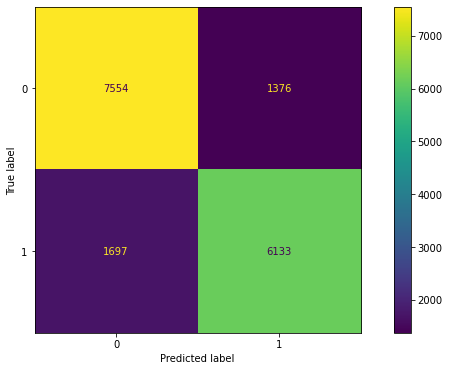

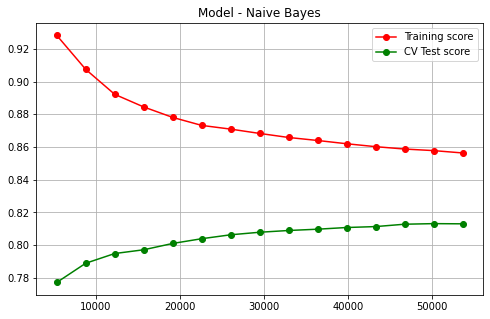

In [55]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_ALL_train_vec, y_ALL_train, X_ALL_test_vec, y_ALL_test)

plot_confusion_matrix(nb_model, X_ALL_test_vec, y_ALL_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_ALL_train_vec, y_ALL_train)

### Naive Bayes - Fine-Tuning

In [56]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_ALL_train, y_ALL_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
Best score: 0.8315830198505287
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------


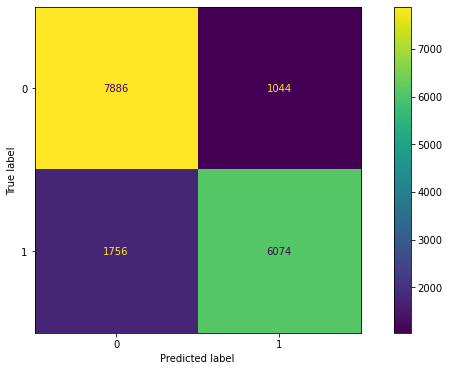

In [57]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_ALL_train, y_ALL_train, X_ALL_test, y_ALL_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ALL_test, y_ALL_test, values_format='d');

### Saving the model

In [58]:
model_name = '../raw_data/ALL_model.joblib'
    
save_model(nb_grid_search.best_estimator_, model_name)

model = get_model(model_name)

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [59]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------


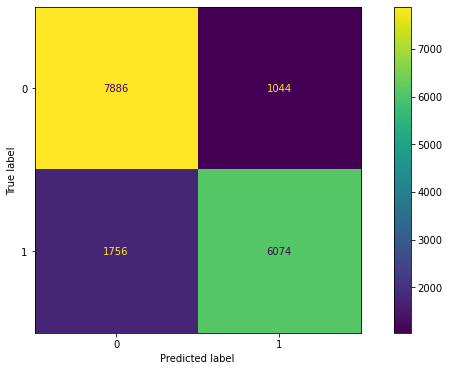

In [60]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_ALL_train, y_ALL_train, X_ALL_test, y_ALL_test)

plot_confusion_matrix(model, X_ALL_test, y_ALL_test, values_format='d');

### `ALL_model.joblib` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.88
Recall: 0.86
Precision: 0.92
f1: 0.89
--------------------------------------------------------------------------------


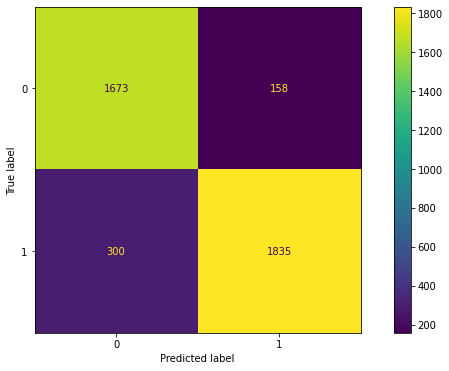

In [61]:
y_preds = model.predict(X_P_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P_test, y_preds)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `ALL_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.91
Recall: 0.72
Precision: 0.87
f1: 0.79
--------------------------------------------------------------------------------


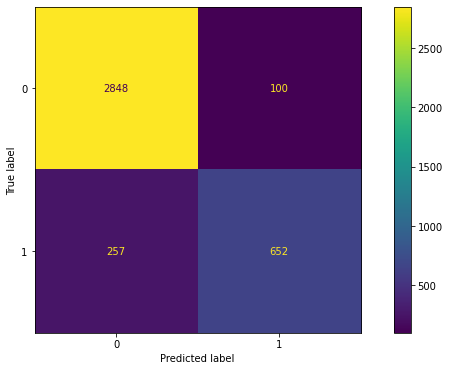

In [62]:
y_preds = model.predict(X_FNN_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN_test, y_preds)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `ALL_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.98
Recall: 0.98
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------


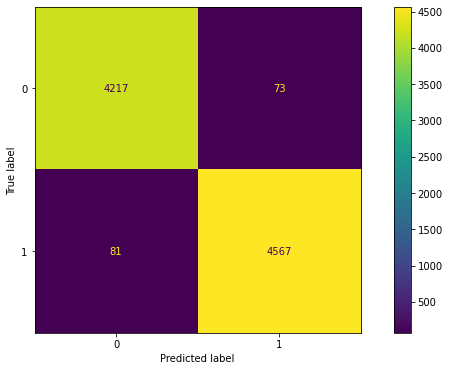

In [63]:
y_preds = model.predict(X_BIS_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS_test, y_preds)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

## Prediction

In [ ]:
model_name = '../raw_data/ALL_model.joblib'

model = get_model(model_name)

In [ ]:
fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [ ]:
sample = [fake0, fake1, fake2, true0, true1, true2]

X_sample_clean = [clean(text) for text in sample] 
# X_sample_clean = sample
# print(X_sample_clean)

y_preds = model.predict_proba(X_sample_clean)[:, 1]

print('-'*80)
print(y_preds)
print('-'*80)